# 変数定義

4 seasons * 7 bandsのデータ

In [1]:
# define vars ---------------------------------------------
under = 90
gpu_list = ['/gpu:0', '/gpu:1']
SEED = 31
DEM = True

# 共通params ---------------------------------------------------
n_trials  = 2**5          # ベイズ最適化回数
outer_cvs = 10
inner_cvs = 10

# CNN Training params ------------------------------------------
train_epochs = 2**5      # エポック数
best_epochs = 2**5       # 最終モデル決定用のエポック数
early_stopping = 2**3    # 

# LightGBM params -----------------------------------------------
lgb_boosting_type = 'gbdt'

import os, zipfile, io, re
os.environ["OMP_NUM_THREADS"] = "3"

# Init

In [2]:
# imports
# Utils -----------------------
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
import random
import pickle
import datetime
import gc
from tqdm import tqdm
import warnings
import seaborn as sns
from glob import glob
import ipynb_path
from math import sqrt
import tifffile
# Machine Learning ---------------
import lightgbm as LGB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans
from optuna import integration
import optuna
import optuna.integration.lightgbm as lgb
# Keras, TensorFlow ---------------
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, BatchNormalization, Convolution2D, Input
from keras import optimizers
from keras.utils import multi_gpu_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings('ignore')
SEED = 31
np.random.seed(SEED)
gpus = len(gpu_list)

Using TensorFlow backend.


In [3]:
# define functions
def pkl_saver(object, pkl_filename):
    with open(pkl_filename, 'wb') as web:
        pickle.dump(object , web)

def pkl_loader(pkl_filename):
    with open(pkl_filename, 'rb') as web:
        data = pickle.load(web)
    return data

def dir_generator(dir_path):
    if os.path.exists(dir_path) == False:
        os.mkdir(dir_path)

def train_import():
    if os.path.exists(data_path + f'df_{N}x{N}.pkl'):
        df = pkl_loader(data_path + f'df_{N}x{N}.pkl')
    else:
        trial = int(len(imgfiles)/28)
        X = [] # X: 説明変数 = (N*N)*(7*4)のデータ
        Y = [] # Y: 目的変数
        point = [] # point: 緯度経度
        X_28 = []
        Y_28 = 0
        point_28 = []
        filenames = []
        max_light = 0
        print('inputdata_processing...')

        for box in tqdm(range(trial)):
            for imgfile in imgfiles[box*28: (box+1)*28]:
                # ZIPから画像読み込み
                image = tifffile.imread(imgfile)
        #         print(image.shape)
                file = os.path.basename(imgfile)
                file_split = [i for i in file.split('_')]
                X_28.append(image)
            Y_28 = file_split[5].split(".")[0]
            point_28 = [float(file_split[1]), float(file_split[2])]
            filenames.append(f"{file_split[0]}_{file_split[1]}_{file_split[2]}_{Y_28}")
            X.append(X_28[box*28: (box+1)*28])
            Y.append(Y_28)
            point.append(point_28)
        del X_28, Y_28, point_28
        X = np.asarray(X)
        print(X.shape)
        X = X.transpose(0,2,3,1)
        print(X.shape)
        Y = np.array(Y)
        filenames = np.array(filenames)
        point = np.array(point)
        region = KMeans(n_clusters = outer_cvs, random_state=SEED).fit(point).labels_
        # label encorder===========================================
        labels = ['Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land' ]
        for i in range(len(labels)):
            Y[Y==labels[i]] = int(i)
        df = [filenames, X, Y, point, region]
        pkl_saver(df, os.path.join(data_path, f'df_{N}x{N}.pkl'))
        
    return df[0], df[1], df[2], df[3], df[4]
def train_transform():
    if os.path.exists(data_path + f'df_{N}x{N}_{standarization[standarization_num]}.pkl'):
        df_train = pkl_loader(data_path + f'df_{N}x{N}_{standarization[standarization_num]}.pkl')
        print("train_df をインポートしたよ！")
    else:
        print("pklを新しく作成中ですが，標準化・正規化のコードに書き直しましたか？")
        X_train_zeros = np.zeros((X_train.shape[0], N*N*28))
        for i in range(len(X_train)):
            for k in range(N):
                for l in range(N):
                    for j in range(28):
                        X_train_zeros[i][j+k+l] = X_train[i][k][l][j]
        # X_train の名前が重複していたので違う名前に変えた. X_train_tmp
        X_train_tmp = X_train_zeros
        df_train = pd.concat([make_df(Y_train), make_df(X_train_tmp)], axis=1)
        pkl_saver(df_train, os.path.join(data_path, f'df_{N}x{N}_{standarization[standarization_num]}.pkl'))
        
    return df_train.iloc[:, 1:], make_df(Y_train)
def train_dem_import():
    if os.path.exists(data_path + f'df_{N}x{N}_dem.pkl'):
        df = pkl_loader(data_path + f'df_{N}x{N}_dem.pkl')
    else:
        trial = int(len(imgfiles)/28)
        X = [] # X: 説明変数 = (N*N)*(7*4)のデータ
        Y = [] # Y: 目的変数
        point = [] # point: 緯度経度
        X_28 = []
        Y_28 = 0
        point_28 = []
        filenames = []
        max_light = 0
        print('inputdata_processing...')

        for box in tqdm(range(trial)):
            for imgfile in imgfiles[box*28: (box+1)*28]:
                # ZIPから画像読み込み
                image = tifffile.imread(imgfile)[0][0]
        #         print(image.shape)
                file = os.path.basename(imgfile)
                file_split = [i for i in file.split('_')]
                X_28.append(image)
            dem_data = tifffile.imread(train_dem_files[box])[0][0]
            X_28.append(dem_data)
            Y_28 = file_split[5].split(".")[0]
            point_28 = [float(file_split[1]), float(file_split[2])]
            filenames.append(f"{file_split[0]}_{file_split[1]}_{file_split[2]}_{Y_28}")
            X.append(X_28[box*29: (box+1)*29])
            Y.append(Y_28)
            point.append(point_28)
    #         if box==100:break
        del X_28, Y_28, point_28
        X = np.asarray(X)
        print(X.shape)
    #     X = X.transpose(0,2,3,1)
        print(X.shape)
        Y = np.array(Y)
        filenames = np.array(filenames)
        point = np.array(point)
        region = KMeans(n_clusters = outer_cvs, random_state=SEED).fit(point).labels_
        # label encorder===========================================
        labels = ['Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land' ]
        for i in range(len(labels)):
            Y[Y==labels[i]] = int(i)
        df = [filenames, X, Y, point, region]
        pkl_saver(df, os.path.join(data_path, f'df_{N}x{N}_dem.pkl'))
    
    return df[0], df[1], df[2], df[3], df[4]
def train_3x3_dem_import():
    if os.path.exists(data_path + f'df_{N}x{N}_dem.pkl'):
        df = pkl_loader(data_path + f'df_{N}x{N}_dem.pkl')
    else:
        trial = int(len(imgfiles)/28)
        X = [] # X: 説明変数 = (N*N)*(7*4)のデータ
        Y = [] # Y: 目的変数
        point = [] # point: 緯度経度
        X_28 = []
        Y_28 = 0
        point_28 = []
        filenames = []
        max_light = 0
        print('inputdata_processing...')

        for box in tqdm(range(trial)):
            for imgfile in imgfiles[box*28: (box+1)*28]:
                # ZIPから画像読み込み
                image = tifffile.imread(imgfile)
        #         print(image.shape)
                file = os.path.basename(imgfile)
                file_split = [i for i in file.split('_')]
                for i in range(N):
                    for j in range(N):
                        X_28.append(image[i][j])
            dem_data = tifffile.imread(train_dem_files[box])
            for i in range(N):
                for j in range(N):
                    X_28.append(dem_data[i*3+1][j*3+1])
            Y_28 = file_split[5].split(".")[0]
            point_28 = [float(file_split[1]), float(file_split[2])]
            filenames.append(f"{file_split[0]}_{file_split[1]}_{file_split[2]}_{Y_28}")
            X.append(X_28[box*29*N*N: (box+1)*29*N*N])
            Y.append(Y_28)
            point.append(point_28)
#             if box==100:break

        del X_28, Y_28, point_28

        X = np.asarray(X)
        print(X.shape)
        Y = np.array(Y)
        filenames = np.array(filenames)
        point = np.array(point)
        region = KMeans(n_clusters = outer_cvs, random_state=SEED).fit(point).labels_
        # label encorder===========================================
        labels = ['Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land' ]
        for i in range(len(labels)):
            Y[Y==labels[i]] = int(i)
        df = [filenames, X, Y, point, region]
        pkl_saver(df, os.path.join(data_path, f'df_{N}x{N}_dem.pkl'))
    
    return df[0], df[1], df[2], df[3], df[4]
        
def test_import():
    if os.path.exists(data_path + f'df_{N}x{N}_testset.pkl'):
        df = pkl_loader(data_path + f'df_{N}x{N}_testset.pkl')
    else:
        trial = int(len(testfiles)/28)
    #     trial = 100
        X = [] # X: 説明変数 = (N*N)*(7*4)のデータ
        Y = [] # Y: 目的変数
        point = [] # point: 緯度経度
        X_28 = []
        Y_28 = 0
        point_28 = []
        filenames = []
        max_light = 0
        print('inputdata_processing...')

        labels = ['Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land' ]
        for box in tqdm(range(trial)):
            for imgfile in testfiles[box*28: (box+1)*28]:
                # ZIPから画像読み込み
                image = tifffile.imread(imgfile)
        #         print(image.shape)
                file = os.path.basename(imgfile)
                file_split = [i for i in file.split('_')]
                X_28.append(image)

            Y_28 = int(file_split[4].split(".")[0]) - 1
    #         print(file_split, Y_28)
            point_28 = [float(file_split[0]), float(file_split[1])]
            filenames.append(f"test_{file_split[0]}_{file_split[1]}_{labels[Y_28]}")
            X.append(X_28[box*28: (box+1)*28])
            Y.append(Y_28)
            point.append(point_28)
        del X_28, Y_28, point_28
        X = np.asarray(X)
        print(X.shape)
        X = X.transpose(0,2,3,1)
        print(X.shape)
        Y = np.array(Y)
        filenames = np.array(filenames)
        point = np.array(point)
        region = KMeans(n_clusters = outer_cvs, random_state=SEED).fit(point).labels_
        df = [filenames, X, Y, point, region]
        pkl_saver(df, os.path.join(data_path, f'df_{N}x{N}_testset.pkl'))
        
    return df
def test_transform():
    if os.path.exists(data_path + f'df_{N}x{N}_test_{standarization[standarization_num]}.pkl'):
        df_test = pkl_loader(data_path + f'df_{N}x{N}_test_{standarization[standarization_num]}.pkl')
        print("test_df をインポートしたよ！")
    else:
        print("pklを新しく作成中ですが，標準化・正規化のコードに書き直しましたか？")
        X_test_zeros = np.zeros((X_test.shape[0], N*N*28))
        for i in range(len(X_test)):
            for k in range(N):
                for l in range(N):
                    for j in range(28):
                        X_test_zeros[i][j+k+l] = X_test[i][k][l][j]
        # X_test の名前が重複していたので違う名前に変えた. X_test_tmp
        X_test_tmp = X_test_zeros
        df_test = pd.concat([make_df(Y_test), make_df(X_test_tmp)], axis=1)
        pkl_saver(df_test, os.path.join(data_path, f'df_{N}x{N}_test_{standarization[standarization_num]}.pkl'))
        
    return df_test.iloc[:, 1:], make_df(Y_test)
def test_dem_import():
    if os.path.exists(data_path + f'df_{N}x{N}_test_dem.pkl'):
        df = pkl_loader(data_path + f'df_{N}x{N}_test_dem.pkl')
    else:
        trial = int(len(testfiles)/28)
        X = [] # X: 説明変数 = (N*N)*(7*4)のデータ
        Y = [] # Y: 目的変数
        point = [] # point: 緯度経度
        X_28 = []
        Y_28 = 0
        point_28 = []
        filenames = []
        max_light = 0
        print('inputdata_processing...')

        for box in tqdm(range(trial)):
            for testfile in testfiles[box*28: (box+1)*28]:
                # ZIPから画像読み込み
                image = tifffile.imread(testfile)
        #         print(image.shape)
                file = os.path.basename(testfile)
                file_split = [i for i in file.split('_')]
                X_28.append(image[0][0])
            dem_data = tifffile.imread(test_dem_files[box])[0][0]
            X_28.append(dem_data)
            Y_28 = file_split[4].split(".")[0]
            point_28 = [float(file_split[0]), float(file_split[1])]
            filenames.append(f"{box}_{file_split[0]}_{file_split[1]}_{Y_28}")
            X.append(X_28[box*29: (box+1)*29])
            Y.append(Y_28)
            point.append(point_28)
    #         if box==100:break
        del X_28, Y_28, point_28
        X = np.asarray(X)
    #     X = X.transpose(0,2,3,1)
        print(X.shape)
        Y = np.array(Y)
        filenames = np.array(filenames)
        point = np.array(point)
        region = KMeans(n_clusters = outer_cvs, random_state=SEED).fit(point).labels_
        # label encorder===========================================
        labels = ['Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land' ]
        for i in range(len(labels)):
            Y[Y==labels[i]] = int(i)
        df = [filenames, X, Y, point, region]
        pkl_saver(df, os.path.join(data_path, f'df_{N}x{N}_test_dem.pkl'))
        
    return df[0], df[1], df[2], df[3], df[4]
def test_3x3_dem_import():
    if os.path.exists(data_path + f'df_{N}x{N}_test_dem.pkl'):
        df = pkl_loader(data_path + f'df_{N}x{N}_test_dem.pkl')
    else:
        trial = int(len(testfiles)/28)
        X = [] # X: 説明変数 = (N*N)*(7*4)のデータ
        Y = [] # Y: 目的変数
        point = [] # point: 緯度経度
        X_28 = []
        Y_28 = 0
        point_28 = []
        filenames = []
        max_light = 0
        print('inputdata_processing...')

        for box in tqdm(range(trial)):
            for testfile in testfiles[box*28: (box+1)*28]:
                # ZIPから画像読み込み
                image = tifffile.imread(testfile)
        #         print(image.shape)
                file = os.path.basename(testfile)
                file_split = [i for i in file.split('_')]
                for i in range(N):
                    for j in range(N):
                        X_28.append(image[i][j])
            dem_data = tifffile.imread(test_dem_files[box])
            for i in range(N):
                for j in range(N):
                    X_28.append(dem_data[i*3+1][j*3+1])
            Y_28 = file_split[4].split(".")[0]
            point_28 = [float(file_split[0]), float(file_split[1])]
            filenames.append(f"{box}_{file_split[0]}_{file_split[1]}_{Y_28}")
            X.append(X_28[box*29*N*N: (box+1)*29*N*N])
            Y.append(Y_28)
            point.append(point_28)
#             if box==100:break
        del X_28, Y_28, point_28
        X = np.asarray(X)
        print(X.shape)
        Y = np.array(Y)
        filenames = np.array(filenames)
        point = np.array(point)
        region = KMeans(n_clusters = outer_cvs, random_state=SEED).fit(point).labels_
        # label encorder===========================================
        labels = ['Water', 'Urban and built-up', 'Rice paddy',  'Crops', 'Grassland', 'DBF', 'DNF', 'EBF', 'ENF', 'Bare land' ]
        for i in range(len(labels)):
            Y[Y==labels[i]] = int(i)
        df = [filenames, X, Y, point, region]
        pkl_saver(df, os.path.join(data_path, f'df_{N}x{N}_test_dem.pkl'))
        
    return df[0], df[1], df[2], df[3], df[4]

def data_splitter_cv(filenames, X, Y, cv, region, point):
    test_index = np.where(region==cv)
    train_index = np.setdiff1d(np.arange(0, X.shape[0], 1), test_index)
    train_files = filenames[train_index]
    test_files = filenames[test_index]
    X_test = X[test_index]
    Y_test = Y[test_index]
    X_train = X[train_index]
    Y_train = Y[train_index]
    train_region = region[train_index]
    train_point = point[train_index]
    return train_files, test_files, X_train, X_test, Y_train, Y_test, train_region, train_point

# Loss Definition ----------------------------------
def opt_cnn(trial):
    # Opt params -----------------------
    # Categorical parameter
    num_layer = trial.suggest_int('num_layer', 1, 2)
    dense_num = trial.suggest_int('dense_num', 3, 7)
    num_filters = [int(trial.suggest_discrete_uniform(f'num_filter_{i}', 7, 10, 1)) for i in range(num_layer)]
    size_filters = [int(trial.suggest_discrete_uniform(f'size_filter_{i}', 3, 3, 1)) for i in range(num_layer)]
    batch_size = trial.suggest_int('batch_size', 1, 5)
    # Model Compiler -----------------------
    lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    decay = trial.suggest_loguniform('decay', 1e-6, 1e-3)
    # Discrete-uniform parameter
    dropout_rate_in = trial.suggest_discrete_uniform('dropout_rate_in', 0.0, 0.5, 0.1)
    dropout_rate_out = trial.suggest_discrete_uniform('dropout_rate_out', 0.0, 0.5, 0.1)
    momentum = trial.suggest_discrete_uniform('momentum', 0.0, 0.5, 0.1)
    # categorical parameter
#    optimizer = trial.suggest_categorical("optimizer", ["sgd", "momentum", "rmsprop", "adam"])
    padding = "same"
#     padding = trial.suggest_categorical('padding', ['same'])
    # compile model-------------------
#     from IPython.core.debugger import Pdb; Pdb().set_trace()
    model = create_model(image_shape, num_layer, padding, dense_num, num_filters, size_filters, dropout_rate_in, dropout_rate_out)
    sgd = optimizers.SGD(lr = lr, decay = decay, momentum = momentum, nesterov = True)
#    sgd = optimizers.SGD(lr = lr, decay = decay, momentum = momentum, nesterov = True, clipvalue = 1.0)
    # For CPU run ------------------
    model.compile(optimizer = sgd, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    # Train Model ----------------------------------
    es_cb = EarlyStopping(monitor = 'val_loss', patience = early_stopping, verbose = 0)
    pr_cb = integration.TFKerasPruningCallback(trial, 'val_loss')
    cbs = [es_cb, pr_cb]
    loss_list, acc_list = [], []
    for inner_cv in range(0, inner_cvs):
        print("outer_cv =", outer_cv, "    inner_cv = ", inner_cv)
        _, _, X_inner_train, X_inner_val, Y_inner_train, Y_inner_val, _, _ = data_splitter_cv(train_files, X_outer_train, Y_outer_train, inner_cv, val_train_region, val_train_point)
        hist = model.fit(
            train_datagen.flow(X_inner_train, Y_inner_train, batch_size = (2**batch_size) * gpus),
            epochs = train_epochs,
            validation_data = (X_inner_val, Y_inner_val),
            callbacks = cbs,
            shuffle = True,
            verbose = 0,
            use_multiprocessing = False)
        loss_list += [model.evaluate(X_inner_val, Y_inner_val)[0]]
        acc_list += [model.evaluate(X_inner_val, Y_inner_val)[1]]
    del model
    keras.backend.clear_session()
    gc.collect()
    eval_loss = np.mean(loss_list)
    eval_acc = np.mean(acc_list)
    print("eval_acc = ", eval_acc)
    return eval_loss

def create_model(image_shape, num_layer, padding, dense_num, num_filters, size_filters, dropout_rate_in, dropout_rate_out):
    inputs = Input(image_shape)
    for d in gpu_list:
        with tf.device(d):
            x = Dropout(dropout_rate_in)(inputs)
            x = Convolution2D(filters = 2**num_filters[0], kernel_size = (size_filters[0],size_filters[0]), padding = "same", activation = 'relu')(x)
            for i in range(1, num_layer):
                x = Convolution2D(filters = 2**num_filters[i],
                                  kernel_size = (size_filters[i], size_filters[i]),
                                  padding = padding,
                                  activation = 'relu')(x)
            x = GlobalAveragePooling2D()(x)
            x = Dropout(dropout_rate_out)(x)
            x = Dense(units = 2**dense_num, activation = 'relu')(x)
            x = Dense(units = num_category, activation = 'softmax')(x)
            model = Model(inputs = inputs, outputs = x)
    return model

def mean_params_calc(param_names):
    dict = {}
    categoricals = ['padding']
    for param_name in param_names:
        data_num = 0
        if param_name not in categoricals:
            for data in best_params:
                try:
                    try:
                        dict[param_name] += data[param_name]
                    except:
                        dict[param_name] = data[param_name]
                    data_num = data_num + 1
                except:
                    pass
            dict[param_name] = dict[param_name]/data_num
        else:
            categorical_list = []
            for data in best_params:
                try:
                    categorical_list = categorical_list + [data[param_name]]
                except:
                    pass
            dict[param_name] = stats.mode(categorical_list)[0][0]
    return dict

def cv_result_imgs_generator(model, history):
    # Visualize Loss Results ----------------------------
    plt.figure(figsize=(18,6))
    plt.plot(history.history["loss"], label="loss", marker="o")
    plt.plot(history.history["val_loss"], label="val_loss", marker="o")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("")
    plt.legend(loc="best")
    plt.grid(color='gray', alpha=0.2)
    plt.savefig('./img_loss/' + str(outer_cv) + '_loss.jpg')
    plt.close()

def region_image_generator(point, region):
    data_num = int(len(imgfiles)/28)
    cmap = plt.get_cmap("tab10")
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(point[:data_num][:,0],point[:data_num][:,1], marker='o', s=5, color=cmap(region))
    ax.set_title("Region in Japan")
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
    ax.set_xlim([120, 155])
    ax.set_ylim([20, 50])
    fig.savefig('./region_separate.png')

def make_dirs(model_name):
    base_path = os.path.join(result_path , model_name)
    # dir generation
    dir_generator(base_path)
    # Chenge current directry
    os.mkdir(os.path.join(base_path, timename))
    os.chdir(os.path.join(base_path, timename))
    dir_generator(model_path)
    dir_generator("./results/")
    dir_generator("./img_loss/")
    dir_generator("./model/")
    dir_generator("./weights/")
    dir_generator("./logs/")
    dir_generator("./outer_cv_times/")

def time_printer(start_time):
    end_time = datetime.datetime.now()
    spend_time = f"Outer_cv time is {end_time - start_time} seconds."
    
# LightGBM ----------------------------------------------------
# -------------------------------------------------------------
def opt_lgb(trial):
    if lgb_boosting_type == "gbdt":
        param_grid_lgb = {
    #         "device": "gpu",
            'boosting_type': lgb_boosting_type,
            'num_leaves': trial.suggest_int("num_leaves", 15, 35),
            'max_depth': trial.suggest_int("max_depth", 5, 15),
    #         'n_estimators': trial.suggest_int("n_estimators", 70, 120),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 0.3),
            "random_state": SEED
        }
    elif lgb_boosting_type =="rf":
        param_grid_lgb = {
            'boosting_type': lgb_boosting_type,
            'num_leaves': trial.suggest_int("num_leaves", 15, 35),
            'max_depth': trial.suggest_int("max_depth", 5, 15),
    #         'n_estimators': trial.suggest_int("n_estimators", 70, 120),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 0.3),
            "random_state": SEED
        }
    
    os.makedirs(f"./results/outer_{outer_cv}", exist_ok=True)
    scores = []
    for inner_cv in range(inner_cvs):
        _, _, X_inner_train, X_inner_val, Y_inner_train, Y_inner_val, _, _ = lgb_splitter_cv(train_files, X_outer_train, Y_outer_train, outer_cv, val_train_region, val_train_point)

        model = LGBMClassifier(**param_grid_lgb)
        model.fit(X_inner_train, Y_inner_train)
        
        scores.append(model.score(X_inner_val, Y_inner_val))
        
        # DEBUG -------------------------------------------------
#         from IPython.core.debugger import Pdb; Pdb().set_trace()
        inner_metr = make_df(confusion_matrix(Y_inner_val.astype(int).values, model.predict(X_inner_val).astype(int)))
        inner_metr.to_csv(f"./results/outer_{outer_cv}/inner_{inner_cv}_acc{round(model.score(X_inner_val, Y_inner_val), 2)}.csv")
    
#     print('mean of inner_val_scores is ', np.mean(scores))
    return np.mean(scores)
def opt_lgb_random(trial):
    if lgb_boosting_type == "gbdt":
        param_grid_lgb = {
    #         "device": "gpu",
            'boosting_type': lgb_boosting_type,
            'num_leaves': trial.suggest_int("num_leaves", 15, 35),
            'max_depth': trial.suggest_int("max_depth", 5, 30),
    #         'n_estimators': trial.suggest_int("n_estimators", 70, 120),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 0.3),
            "random_state": SEED
        }
    elif lgb_boosting_type =="rf":
        param_grid_lgb = {
            'boosting_type': lgb_boosting_type,
            'num_leaves': trial.suggest_int("num_leaves", 15, 35),
            'max_depth': trial.suggest_int("max_depth", 5, 30),
    #         'n_estimators': trial.suggest_int("n_estimators", 70, 120),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 0.3),
            "random_state": SEED
        }
    
    os.makedirs(f"./results/outer_{outer_cv}", exist_ok=True)
    scores = []
    skf = StratifiedKFold(n_splits=inner_cvs, random_state=SEED, shuffle=False)
    inner_cv = 0
    X_valid  = X_outer_train
    Y_valid  = Y_outer_train
#     X_valid  = X_outer_train.values
#     Y_valid  = Y_outer_train.values
    for train_index, valid_index in skf.split(X_valid, Y_valid):
        # DEBUG -------------------------------------------------
#         from IPython.core.debugger import Pdb; Pdb().set_trace()
        
        X_inner_train, X_inner_val = X_outer_train[train_index], X_outer_train[valid_index]
        Y_inner_train, Y_inner_val = Y_outer_train[train_index], Y_outer_train[valid_index]
#         X_inner_train, X_inner_val = X_outer_train.to_numpy()[train_index], X_outer_train.to_numpy()[valid_index]
#         Y_inner_train, Y_inner_val = Y_outer_train.to_numpy()[train_index], Y_outer_train.to_numpy()[valid_index]

        model = LGBMClassifier(**param_grid_lgb)
        model.fit(X_inner_train, Y_inner_train)
        
        scores.append(model.score(X_inner_val, Y_inner_val))
        
        inner_cv += 1
#     print('mean of inner_val_scores is ', np.mean(scores))
    return np.mean(scores)

def lgb_splitter_cv(filenames, X, Y, cv, region, point):
#     from IPython.core.debugger import Pdb; Pdb().set_trace()
    test_index = np.where(region==cv)
    train_index = np.setdiff1d(np.arange(0, X.shape[0], 1), test_index)
    train_files = filenames[train_index]
    test_files = filenames[test_index]
    X_test = np.array(X)[test_index]
    Y_test = np.array(Y)[test_index]
    X_train = np.array(X)[train_index]
    Y_train = np.array(Y)[train_index]
    train_region = region[train_index]
    train_point = point[train_index]
    X_train, X_test, Y_train, Y_test = make_df(X_train), make_df(X_test), make_df(Y_train), make_df(Y_test)
    return train_files, test_files, X_train, X_test, Y_train, Y_test, train_region, train_point

def make_df(X):
    return pd.DataFrame(X)

# Model

## LightGBM (1x1 pixel)

In [4]:
# Data Loader ------------------------------------------------------------------------
standarization = ["normalization", "Zscore", "normal", "dem"] # pklを作るまではCodeの書き換えも必要だよ！
standarization_num= 2
N=1

##### Data Loader ------------------------------
if under==20:
    train_tif_name = f"D:/LULC/features/01_landsat8/train_old/{N}x{N}"
elif under==90:
    train_tif_name = f"D:/LULC/features/01_landsat8/train_new/{N}x{N}"

testfiles = glob(f"D:/LULC/features/01_landsat8/train_new/{N}x{N}_test" + "/*.tif")
testfiles.sort()

root_path      = f"C:/Users/GE/Dropbox/Kairo/under{under}_results/"
result_path    = f"C:/Users/GE/Dropbox/Kairo/under{under}_results/{N}x{N}"
data_path      = f"C:/Users/GE/Dropbox/Kairo/under{under}_results/data/"
model_path     = f"C:/Users/GE/Dropbox/Kairo/under{under}_results/model/{N}x{N}/"
imgfiles = glob(train_tif_name + "/*.tif")
imgfiles.sort()
model_trained = False

# data import ---------------------------------------------------------------------------
timename       = '{0:%Y_%m%d_%H%M}'.format(datetime.datetime.now())
time_path      =  os.path.join(result_path, lgb_boosting_type, timename, "outer_cv_times")
make_dirs(lgb_boosting_type)
# ------------train import----------------------
X_files, X_train, Y_train, train_point, region_train = train_import()
image_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
num_category = len(np.unique(Y_train))
X_train = X_train.astype(np.float64)
Y_train = Y_train.astype(np.float64)
# ------------test import----------------------
Y_files, X_test, Y_test, test_point, region_test = test_import()
X_test = X_test.astype(np.float64)


# Data converter ----------------------------------------------
X_train, Y_train = train_transform()
X_test, Y_test = test_transform()

train_df をインポートしたよ！
test_df をインポートしたよ！


In [5]:
# REMOVE datalack of train and test
X_files = make_df(X_files)
X_train =  make_df(X_train)
Y_train = make_df(Y_train)

del_index = []
for i in range(len(X_train)):
    if sum(X_train.loc[i]==0)>7:
        del_index.append(i)
X_files.drop(index=del_index, inplace=True)
X_train.drop(index=del_index, inplace=True)
Y_train.drop(index=del_index, inplace=True)




Y_files = make_df(Y_files)
X_test =  make_df(X_test)
Y_test = make_df(Y_test)

del_index = []
for i in range(len(X_test)):
    if sum(X_test.loc[i]==0)>7:
        del_index.append(i)
Y_files.drop(index=del_index, inplace=True)
X_test.drop(index=del_index, inplace=True)
Y_test.drop(index=del_index, inplace=True)

# X_train  = X_train.values
# Y_train  = Y_train.values
# X_test  = X_test.values
# Y_test  = Y_test.values

In [6]:
Y_train[Y_train==3] = 2
Y_train[Y_train==4] = 3
Y_train[Y_train==5] = 4
Y_train[Y_train==6] = 4
Y_train[Y_train==7] = 5
Y_train[Y_train==8] = 5
Y_train[Y_train==9] = 6

Y_test[Y_test==3] = 2
Y_test[Y_test==4] = 3
Y_test[Y_test==5] = 4
Y_test[Y_test==6] = 4
Y_test[Y_test==7] = 5
Y_test[Y_test==8] = 5
Y_test[Y_test==9] = 6

In [7]:
print(np.unique(Y_train.values), np.unique(Y_test.values))

[0. 1. 2. 3. 4. 5. 6.] [0 1 2 3 4 5 6]


In [8]:
# import data_shape check -------------------------------------------------------------
print("X_train: ", type(X_train), X_train.shape)
print("Y_train: ", type(Y_train), Y_train.shape)
print("X_test: ", type(X_test), X_test.shape)
print("Y_test: ", type(Y_test), Y_test.shape)

X_train:  <class 'pandas.core.frame.DataFrame'> (33733, 28)
Y_train:  <class 'pandas.core.frame.DataFrame'> (33733, 1)
X_test:  <class 'pandas.core.frame.DataFrame'> (2878, 28)
Y_test:  <class 'pandas.core.frame.DataFrame'> (2878, 1)


In [9]:
# del Y_val_files, lgb_scores, lgb_best_params,  Y_val_smx, Y_val_pred, Y_val_obs
X_files = X_files.to_numpy()

In [10]:
CV_type =  "random"  # "random" or sparse"

In [11]:
# train start -----------------------------------------------------------------------------
if CV_type == "random":
    print("CV is RANDOM!!!")
    train_start = datetime.datetime.now()
    # region_image_generator(train_point, region_train)
    SKF = StratifiedKFold(n_splits=outer_cvs, random_state=SEED, shuffle=False)
    outer_cv = 0
    for train_index, valid_index in SKF.split(X_train, Y_train):
        os.makedirs(f"./results/outer_{outer_cv}", exist_ok=True)
        X_outer_train, X_outer_val = X_train.to_numpy()[train_index], X_train.to_numpy()[valid_index]
        Y_outer_train, Y_outer_val = Y_train.to_numpy()[train_index], Y_train.to_numpy()[valid_index]

        outer_start = datetime.datetime.now()
        print(f'outer_cv_{outer_cv}_processing....')
        # Data Loader-------------------------------------

        study = optuna.create_study(direction='maximize')
        study.optimize(opt_lgb_random, n_trials=n_trials)
    #     print(study.best_value)

        lgb_best_param = study.best_paramsrams
        lgb_best = LGBMClassifier(**lgb_best_param)
        lgb_best.fit(X_outer_train, Y_outer_train)

        print('mean of outer_val_scores is ', (np.array(lgb_best.predict(X_outer_val).astype(int) == Y_outer_val[:,0].astype(int)).sum() / len(Y_outer_val) ) )
        print('mean of test_scores is ',      (np.array(lgb_best.predict(X_test.values).astype(int)      == Y_test.astype(int)[0].values).sum() / len(Y_test) ) )
        #     print(lgb_best.predict_proba(X_outer_val).argmax(axis=1))

        try:
            Y_val_files.append(X_files[valid_index])
        except:
            Y_val_files =  [X_files[valid_index]]    
        try:
            lgb_scores.append(np.array(lgb_best.predict(X_outer_val).astype(int) == Y_outer_val.astype(int)[0]).sum() / len(Y_outer_val))
        except:
            lgb_scores = [np.array(lgb_best.predict(X_outer_val).astype(int) == Y_outer_val.astype(int)[0]).sum() / len(Y_outer_val)]
        try:
            lgb_best_params.append(lgb_best_param)
        except:
            lgb_best_params = [lgb_best_param]
        try:
            Y_val_smx.append(np.array(lgb_best.predict_proba(X_outer_val)))
        except:
            Y_val_smx = [np.array(lgb_best.predict_proba(X_outer_val))]
        try:
            Y_val_pred.append(lgb_best.predict(X_outer_val).astype(int))
        except:
            Y_val_pred = [lgb_best.predict(X_outer_val).astype(int)]
        try:
            Y_val_obs.append(Y_outer_val[0].astype(int))
        except:
            Y_val_obs =  [Y_outer_val[0].astype(int)]

        outer_end = datetime.datetime.now()
        spend_time = f"Outer_cv time is {outer_end - outer_start} seconds."
        pkl_saver(spend_time, os.path.join(time_path, f"outer_cv_{outer_cv}_time.txt"))


        outer_metr = make_df(confusion_matrix(Y_outer_val.astype(int), lgb_best.predict(X_outer_val).astype(int)))
        outer_metr.to_csv(f"./results/outer_{outer_cv}/outer_{outer_cv}_acc{round(lgb_best.score(X_outer_val, Y_outer_val), 2)}.csv")
        test_metr = make_df(confusion_matrix(Y_test.astype(int), lgb_best.predict(X_test).astype(int)))
        test_metr.to_csv(f"./results/outer_{outer_cv}/test_acc{round(lgb_best.score(X_test, Y_test), 2)}.csv")
        outer_cv += 1

    train_end = datetime.datetime.now()
    spend_time = f"Outer_cv time is {train_end - train_start} seconds."
    pkl_saver(spend_time, os.path.join(time_path, "all_time.txt"))

elif CV_type == "sparse":
    # train start -----------------------------------------------------------------------------
    train_start = datetime.datetime.now()
    region_image_generator(train_point, region_train)

    for outer_cv in range(outer_cvs):
        print("CV is SPARTIAL!!!")
        outer_start = datetime.datetime.now()
        print(f'outer_cv_{outer_cv}_processing....')
        # Data Loader-------------------------------------
        train_files, val_files, X_outer_train, X_outer_val, Y_outer_train, Y_outer_val, val_train_region, val_train_point = lgb_splitter_cv(X_files, X_train, Y_train, outer_cv, region_train, train_point)
        val_train_region = KMeans(n_clusters = outer_cvs, random_state=SEED).fit(val_train_point).labels_    

        study = optuna.create_study(direction='maximize')
        study.optimize(opt_lgb, n_trials=n_trials)
    #     print(study.best_value)

        lgb_best_param = study.best_params
        lgb_best = LGBMClassifier(**lgb_best_param)
        lgb_best.fit(X_outer_train, Y_outer_train)

        print('mean of outer_val_scores is ', (np.array(lgb_best.predict(X_outer_val).astype(int) == Y_outer_val.astype(int)[0].values).sum() / len(Y_outer_val) ) )
        print('mean of test_scores is ',      (np.array(lgb_best.predict(X_test).astype(int)      == Y_test.astype(int)[0].values).sum() / len(Y_test) ) )
        #     print(lgb_best.predict_proba(X_outer_val).argmax(axis=1))

        try:
            Y_val_files.append(val_files)
        except:
            Y_val_files =  [val_files]    
        try:
            lgb_scores.append(np.array(lgb_best.predict(X_outer_val).astype(int) == Y_outer_val.astype(int)[0].values).sum() / len(Y_outer_val))
        except:
            lgb_scores = [np.array(lgb_best.predict(X_outer_val).astype(int) == Y_outer_val.astype(int)[0].values).sum() / len(Y_outer_val)]
        try:
            lgb_best_params.append(lgb_best_param)
        except:
            lgb_best_params = [lgb_best_param]
        try:
            Y_val_smx.append(np.array(lgb_best.predict_proba(X_outer_val)))
        except:
            Y_val_smx = [np.array(lgb_best.predict_proba(X_outer_val))]
        try:
            Y_val_pred.append(lgb_best.predict(X_outer_val).astype(int))
        except:
            Y_val_pred = [lgb_best.predict(X_outer_val).astype(int)]
        try:
            Y_val_obs.append(Y_outer_val[0].values.astype(int))
        except:
            Y_val_obs =  [Y_outer_val[0].values.astype(int)]

        outer_end = datetime.datetime.now()
        spend_time = f"Outer_cv time is {outer_end - outer_start} seconds."
        pkl_saver(spend_time, os.path.join(time_path, f"outer_cv_{outer_cv}_time.txt"))

    train_end = datetime.datetime.now()
    spend_time = f"Outer_cv time is {train_end - train_start} seconds."
    pkl_saver(spend_time, os.path.join(time_path, "all_time.txt"))
    
else: print("Please enter the correct CV nam.e")

CV is RANDOM!!!
outer_cv_0_processing....


[I 2020-12-17 16:27:39,783] Finished trial#0 resulted in value: 0.4433611163566038. Current best value is 0.4433611163566038 with parameters: {'num_leaves': 32, 'max_depth': 30, 'learning_rate': 0.00027633626882888484}.
[I 2020-12-17 16:28:00,802] Finished trial#1 resulted in value: 0.4433611163566038. Current best value is 0.4433611163566038 with parameters: {'num_leaves': 32, 'max_depth': 30, 'learning_rate': 0.00027633626882888484}.
[I 2020-12-17 16:28:30,523] Finished trial#2 resulted in value: 0.4433611163566038. Current best value is 0.4433611163566038 with parameters: {'num_leaves': 32, 'max_depth': 30, 'learning_rate': 0.00027633626882888484}.
[I 2020-12-17 16:29:05,157] Finished trial#3 resulted in value: 0.7841827450061101. Current best value is 0.7841827450061101 with parameters: {'num_leaves': 35, 'max_depth': 16, 'learning_rate': 0.19553305997821208}.
[I 2020-12-17 16:29:30,630] Finished trial#4 resulted in value: 0.4433611163566038. Current best value is 0.784182745006110

mean of outer_val_scores is  0.7643746295198577
mean of test_scores is  0.8009034051424601
outer_cv_1_processing....


[I 2020-12-17 16:44:09,213] Finished trial#0 resulted in value: 0.4433611163566038. Current best value is 0.4433611163566038 with parameters: {'num_leaves': 29, 'max_depth': 24, 'learning_rate': 2.1867333150226518e-06}.
[I 2020-12-17 16:44:34,478] Finished trial#1 resulted in value: 0.4433611163566038. Current best value is 0.4433611163566038 with parameters: {'num_leaves': 29, 'max_depth': 24, 'learning_rate': 2.1867333150226518e-06}.
[I 2020-12-17 16:44:57,925] Finished trial#2 resulted in value: 0.4433611163566038. Current best value is 0.4433611163566038 with parameters: {'num_leaves': 29, 'max_depth': 24, 'learning_rate': 2.1867333150226518e-06}.
[I 2020-12-17 16:45:31,797] Finished trial#3 resulted in value: 0.4433611163566038. Current best value is 0.4433611163566038 with parameters: {'num_leaves': 29, 'max_depth': 24, 'learning_rate': 2.1867333150226518e-06}.
[I 2020-12-17 16:46:06,725] Finished trial#4 resulted in value: 0.743041503061559. Current best value is 0.7430415030615

mean of outer_val_scores is  0.8034973325429757
mean of test_scores is  0.7887421820708825
outer_cv_2_processing....


[I 2020-12-17 16:59:53,859] Finished trial#0 resulted in value: 0.4433611163566038. Current best value is 0.4433611163566038 with parameters: {'num_leaves': 33, 'max_depth': 18, 'learning_rate': 0.0009043035163183883}.
[I 2020-12-17 17:00:23,097] Finished trial#1 resulted in value: 0.4433611163566038. Current best value is 0.4433611163566038 with parameters: {'num_leaves': 33, 'max_depth': 18, 'learning_rate': 0.0009043035163183883}.
[I 2020-12-17 17:00:52,762] Finished trial#2 resulted in value: 0.6613193137593252. Current best value is 0.6613193137593252 with parameters: {'num_leaves': 25, 'max_depth': 14, 'learning_rate': 0.007966731532607768}.
[I 2020-12-17 17:01:25,916] Finished trial#3 resulted in value: 0.7625418753106599. Current best value is 0.7625418753106599 with parameters: {'num_leaves': 29, 'max_depth': 13, 'learning_rate': 0.05659250126581955}.
[I 2020-12-17 17:01:47,086] Finished trial#4 resulted in value: 0.7018672687768741. Current best value is 0.7625418753106599 wi

mean of outer_val_scores is  0.8144635447540012
mean of test_scores is  0.7922168172341905
outer_cv_3_processing....


[I 2020-12-17 17:14:26,159] Finished trial#0 resulted in value: 0.4433465085638998. Current best value is 0.4433465085638998 with parameters: {'num_leaves': 25, 'max_depth': 8, 'learning_rate': 0.002801163193953159}.
[I 2020-12-17 17:14:52,868] Finished trial#1 resulted in value: 0.4433465085638998. Current best value is 0.4433465085638998 with parameters: {'num_leaves': 25, 'max_depth': 8, 'learning_rate': 0.002801163193953159}.
[I 2020-12-17 17:15:17,529] Finished trial#2 resulted in value: 0.4433465085638998. Current best value is 0.4433465085638998 with parameters: {'num_leaves': 25, 'max_depth': 8, 'learning_rate': 0.002801163193953159}.
[I 2020-12-17 17:15:51,689] Finished trial#3 resulted in value: 0.4433465085638998. Current best value is 0.4433465085638998 with parameters: {'num_leaves': 25, 'max_depth': 8, 'learning_rate': 0.002801163193953159}.
[I 2020-12-17 17:16:22,602] Finished trial#4 resulted in value: 0.4433465085638998. Current best value is 0.4433465085638998 with pa

mean of outer_val_scores is  0.8108508745923511
mean of test_scores is  0.7807505211952745
outer_cv_4_processing....


[I 2020-12-17 17:30:05,145] Finished trial#0 resulted in value: 0.4433465085638998. Current best value is 0.4433465085638998 with parameters: {'num_leaves': 30, 'max_depth': 8, 'learning_rate': 5.8526562280182276e-05}.
[I 2020-12-17 17:30:37,994] Finished trial#1 resulted in value: 0.4433465085638998. Current best value is 0.4433465085638998 with parameters: {'num_leaves': 30, 'max_depth': 8, 'learning_rate': 5.8526562280182276e-05}.
[I 2020-12-17 17:31:15,348] Finished trial#2 resulted in value: 0.7570158102766799. Current best value is 0.7570158102766799 with parameters: {'num_leaves': 34, 'max_depth': 22, 'learning_rate': 0.036125063841223985}.
[I 2020-12-17 17:31:42,843] Finished trial#3 resulted in value: 0.5066864295125164. Current best value is 0.7570158102766799 with parameters: {'num_leaves': 34, 'max_depth': 22, 'learning_rate': 0.036125063841223985}.
[I 2020-12-17 17:32:09,198] Finished trial#4 resulted in value: 0.4433465085638998. Current best value is 0.7570158102766799 w

mean of outer_val_scores is  0.7886154758375333
mean of test_scores is  0.7981236970118137
outer_cv_5_processing....


[I 2020-12-17 17:45:37,010] Finished trial#0 resulted in value: 0.4433135704874835. Current best value is 0.4433135704874835 with parameters: {'num_leaves': 23, 'max_depth': 12, 'learning_rate': 2.4913003475074698e-08}.
[I 2020-12-17 17:46:04,247] Finished trial#1 resulted in value: 0.4433135704874835. Current best value is 0.4433135704874835 with parameters: {'num_leaves': 23, 'max_depth': 12, 'learning_rate': 2.4913003475074698e-08}.
[I 2020-12-17 17:46:38,474] Finished trial#2 resulted in value: 0.6315217391304349. Current best value is 0.6315217391304349 with parameters: {'num_leaves': 33, 'max_depth': 28, 'learning_rate': 0.006087318670056482}.
[I 2020-12-17 17:47:02,723] Finished trial#3 resulted in value: 0.4433135704874835. Current best value is 0.6315217391304349 with parameters: {'num_leaves': 33, 'max_depth': 28, 'learning_rate': 0.006087318670056482}.
[I 2020-12-17 17:47:28,415] Finished trial#4 resulted in value: 0.4433135704874835. Current best value is 0.6315217391304349

mean of outer_val_scores is  0.7266528313074414
mean of test_scores is  0.784920083391244
outer_cv_6_processing....


[I 2020-12-17 17:58:40,901] Finished trial#0 resulted in value: 0.4433135704874835. Current best value is 0.4433135704874835 with parameters: {'num_leaves': 19, 'max_depth': 30, 'learning_rate': 0.0003620181552755444}.
[I 2020-12-17 17:59:10,659] Finished trial#1 resulted in value: 0.4433135704874835. Current best value is 0.4433135704874835 with parameters: {'num_leaves': 19, 'max_depth': 30, 'learning_rate': 0.0003620181552755444}.
[I 2020-12-17 17:59:42,036] Finished trial#2 resulted in value: 0.4433135704874835. Current best value is 0.4433135704874835 with parameters: {'num_leaves': 19, 'max_depth': 30, 'learning_rate': 0.0003620181552755444}.
[I 2020-12-17 18:00:04,647] Finished trial#3 resulted in value: 0.7354743083003953. Current best value is 0.7354743083003953 with parameters: {'num_leaves': 15, 'max_depth': 10, 'learning_rate': 0.025149039696402958}.
[I 2020-12-17 18:00:28,669] Finished trial#4 resulted in value: 0.4433135704874835. Current best value is 0.7354743083003953 

mean of outer_val_scores is  0.7539282537800178
mean of test_scores is  0.7970813064628214
outer_cv_7_processing....


[I 2020-12-17 18:15:09,427] Finished trial#0 resulted in value: 0.7487483530961792. Current best value is 0.7487483530961792 with parameters: {'num_leaves': 25, 'max_depth': 15, 'learning_rate': 0.026847112241018704}.
[I 2020-12-17 18:15:41,796] Finished trial#1 resulted in value: 0.7604084321475626. Current best value is 0.7604084321475626 with parameters: {'num_leaves': 27, 'max_depth': 30, 'learning_rate': 0.04249817694468063}.
[I 2020-12-17 18:16:10,282] Finished trial#2 resulted in value: 0.7575428194993412. Current best value is 0.7604084321475626 with parameters: {'num_leaves': 27, 'max_depth': 30, 'learning_rate': 0.04249817694468063}.
[I 2020-12-17 18:16:45,193] Finished trial#3 resulted in value: 0.7405797101449276. Current best value is 0.7604084321475626 with parameters: {'num_leaves': 27, 'max_depth': 30, 'learning_rate': 0.04249817694468063}.
[I 2020-12-17 18:17:12,453] Finished trial#4 resulted in value: 0.7738801054018445. Current best value is 0.7738801054018445 with p

mean of outer_val_scores is  0.7557070856804032
mean of test_scores is  0.7974287699791522
outer_cv_8_processing....


[I 2020-12-17 18:29:16,861] Finished trial#0 resulted in value: 0.4433135704874835. Current best value is 0.4433135704874835 with parameters: {'num_leaves': 26, 'max_depth': 10, 'learning_rate': 3.020757514253423e-08}.
[I 2020-12-17 18:29:47,130] Finished trial#1 resulted in value: 0.4433135704874835. Current best value is 0.4433135704874835 with parameters: {'num_leaves': 26, 'max_depth': 10, 'learning_rate': 3.020757514253423e-08}.
[I 2020-12-17 18:30:12,283] Finished trial#2 resulted in value: 0.7172595520421609. Current best value is 0.7172595520421609 with parameters: {'num_leaves': 18, 'max_depth': 19, 'learning_rate': 0.016424578855557485}.
[I 2020-12-17 18:30:46,590] Finished trial#3 resulted in value: 0.5295125164690381. Current best value is 0.7172595520421609 with parameters: {'num_leaves': 18, 'max_depth': 19, 'learning_rate': 0.016424578855557485}.
[I 2020-12-17 18:31:13,190] Finished trial#4 resulted in value: 0.7279973649538868. Current best value is 0.7279973649538868 w

mean of outer_val_scores is  0.7812036762525941
mean of test_scores is  0.7883947185545518
outer_cv_9_processing....


[I 2020-12-17 18:44:06,620] Finished trial#0 resulted in value: 0.4433135704874835. Current best value is 0.4433135704874835 with parameters: {'num_leaves': 21, 'max_depth': 26, 'learning_rate': 2.2781457534248208e-05}.
[I 2020-12-17 18:44:22,590] Finished trial#1 resulted in value: 0.6123517786561266. Current best value is 0.6123517786561266 with parameters: {'num_leaves': 18, 'max_depth': 20, 'learning_rate': 0.0064840430075056845}.
[I 2020-12-17 18:44:43,457] Finished trial#2 resulted in value: 0.4433135704874835. Current best value is 0.6123517786561266 with parameters: {'num_leaves': 18, 'max_depth': 20, 'learning_rate': 0.0064840430075056845}.
[I 2020-12-17 18:45:03,065] Finished trial#3 resulted in value: 0.7761198945981556. Current best value is 0.7761198945981556 with parameters: {'num_leaves': 29, 'max_depth': 19, 'learning_rate': 0.11871213651817807}.
[I 2020-12-17 18:45:18,893] Finished trial#4 resulted in value: 0.4433135704874835. Current best value is 0.7761198945981556 

mean of outer_val_scores is  0.7874295879039431
mean of test_scores is  0.7956914523974983


'./code/LULC_落葉広葉チェック_7クラス分類.ipynb'

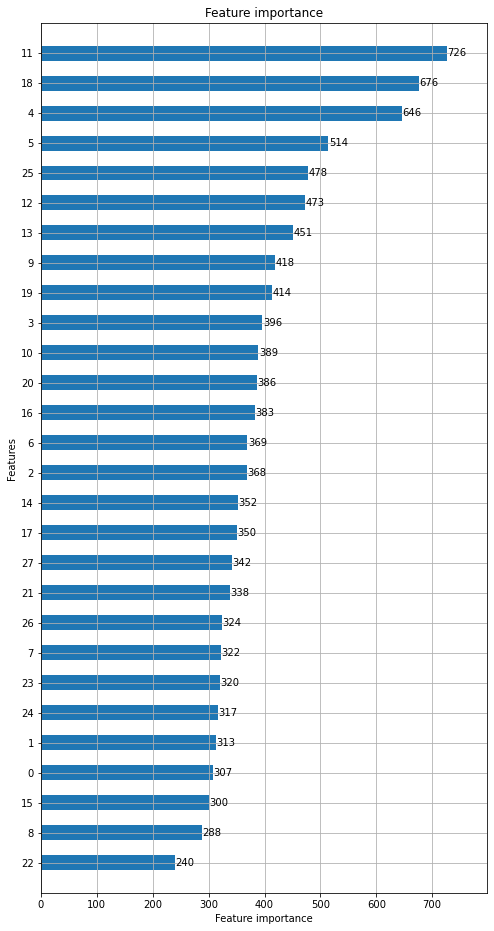

In [12]:
# Save 7_classes Results -------------------------------------------------------------------------
best_trial_num = np.argmax(lgb_scores)

np.savetxt('Y_val_smx.txt', Y_val_smx[:][best_trial_num])
param_names = lgb_best_params[list(map(len, lgb_best_params)).index(max(list(map(len, lgb_best_params))))].keys()
best_params_dict = lgb_best_params[best_trial_num]
pkl_saver(lgb_best_params, 'best_params_list.csv')
pkl_saver(lgb_best_params, 'best_params.csv')
best_params_dict = pkl_loader('best_params.csv')

# Save CV_Result to csv -------------------------------------------------

# results = [Y_val_files[best_trial_num], Y_val_obs[best_trial_num], Y_val_pred[best_trial_num], Y_val_smx[:][best_trial_num]]
# pkl_saver(results, './results/results.pkl')
# make_df(val_files)
# results_csv = np.concatenate([make_df(Y_val_files[best_trial_num]),make_df(Y_val_obs[best_trial_num]), make_df(Y_val_pred[best_trial_num]), make_df(Y_val_smx[:][best_trial_num])], 1)
# results_csv = pd.DataFrame(results_csv)
columns = ["name", "obs", "pred", 'Water', 'Urban and built-up', 'Crops', 'Grassland', "DF", "EF", 'Bare land']
# results_csv.columns=columns
# results_csv.to_csv('./results/results_val.csv')
labels = ['Water', 'Urban and built-up', 'Crops', 'Grassland', "DF", "EF", 'Bare land']

# res_smr = classification_report(list(results_csv['obs'].astype(int)), list(results_csv['pred']), target_names = labels, labels = np.array(range(len(labels))))
# with open('./results/result_summary_val.txt','w') as f:
#     f.write(res_smr)

# Best Model Training -----------------------------------------------
best_model = LGBMClassifier(**lgb_best_params[best_trial_num])
best_model.fit(X_train, Y_train)

# results_csv.columns=columns
# results_csv.to_csv('./results/results_test.csv')
cf_metr = confusion_matrix(Y_test.astype(int).values, best_model.predict(X_test).astype(int))
cf_metr = pd.DataFrame(cf_metr)
cf_metr.columns=labels
cf_metr.index=labels
cf_metr.to_csv("./results/confusion_matrix_test.csv")

# ugokanaikamo 
LGB.plot_importance(best_model, height = 0.5, figsize = (8,16))
plt.savefig('./figure.png')

# Save Model -----------------------------------
pickle.dump(best_model, open("./best_model.pkl", 'wb'))

# Save Code
import shutil
os.mkdir("./code")
code_name = ipynb_path.get().split("/")[-1]
shutil.copy(ipynb_path.get(), f"./code/{code_name}")

In [13]:
read_model = pickle.load(open('./best_model.pkl', 'rb'))

In [19]:
file_time_name = timename

In [14]:
# Show Accuracy --------------------------------------------------------------------------
acc = round(np.array(read_model.predict(X_test).astype(int) == Y_test.astype(int)[0].values).sum() / len(Y_test), 3)*100
print(acc)
if CV_type == "random":
    pkl_saver(acc, f'randomCV_acc_{acc}.txt')
elif CV_type == "sparse":
    pkl_saver(acc, f'spartialCV_acc_{acc}.txt')

78.8


In [ ]:
file_time_name = "2020_1209_1909"
os.chdir(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}")
read_model = pickle.load(open('./best_model.pkl', 'rb'))

In [ ]:
# SAVING OBS but PRED VISUALIZATIONS ------------------------------------
pred = read_model.predict(X_test).astype(int)
obs = Y_test.astype(int)[0].values
lon, lat = [], []
for i in range(len(Y_files)):
    lon.append(float(Y_files.values[i][0].split("_")[1]))
    lat.append(float(Y_files.values[i][0].split("_")[2]))
os.makedirs(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization", exist_ok=True)
os.chdir(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization")
labels = ['Water', 'Urban and built-up',  'Crops', 'Grassland', 'DF', 'EF', 'Bare land']

df_lon = make_df(lon)
df_lat = make_df(lat)
df_pred = make_df(pred)
df_obs = make_df(obs)
results = pd.concat([df_lon, df_lat, df_pred, df_obs], axis=1)
results.columns = ["lon", "lat", "pred", "obs"]

os.makedirs(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/csv", exist_ok=True)
os.chdir(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/csv")
results[results["pred"]!=results["obs"]].to_csv("./miss_all.csv")
for i in range(10):
    obs_lis = results[results["pred"]!=results["obs"]][results["obs"]==i]
    pred_lis = results[results["pred"]!=results["obs"]][results["pred"]==i]
    obs_lis.to_csv(f"./obs_{i}.csv")
    pred_lis.to_csv(f"./pred_{i}.csv")


os.makedirs(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_point_check", exist_ok=True)
os.chdir(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_point_check")
for i in range(10):
    obs_lis = results[results["pred"]!=results["obs"]][results["obs"]==i]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    for j in range(10):
        pred_j = results[results["pred"]!=results["obs"]][results["obs"]==i][results["pred"]==j]
        if len(pred_j)==0: continue
        ax.set_title(f'OBS = {labels[i]}')
        ax.scatter(pred_j["lon"].values.astype(np.float64), pred_j["lat"].values.astype(np.float64), label=labels[j], s=10)
        ax.set_xlim([120, 155])
        ax.set_ylim([20, 50])
        
        ax.legend(loc='upper left')
        plt.savefig(f"./obs_{labels[i]}.png")


plt.show()

In [21]:
labels = ['Water', 'Urban and built-up', 'Crops', 'Grassland', 'DF', 'EF', 'Bare land']
pred = read_model.predict(X_test).astype(int)
obs = Y_test.astype(int)[0].values
lon, lat = [], []
for i in range(len(Y_files)):
    lon.append(float(Y_files.values[i][0].split("_")[1]))
    lat.append(float(Y_files.values[i][0].split("_")[2]))

df_lon = make_df(lon)
df_lat = make_df(lat)
df_pred = make_df(pred)
df_obs = make_df(obs)
results = pd.concat([df_lon, df_lat, df_pred, df_obs], axis=1)
results.columns = ["lon", "lat", "pred", "obs"]

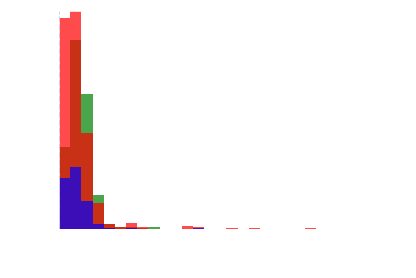

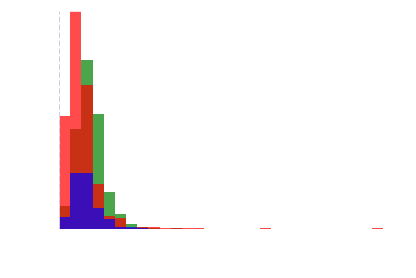

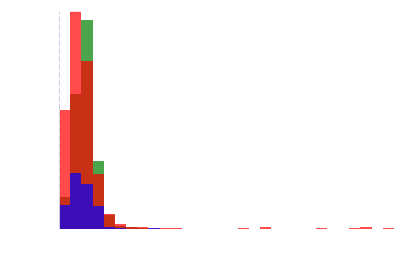

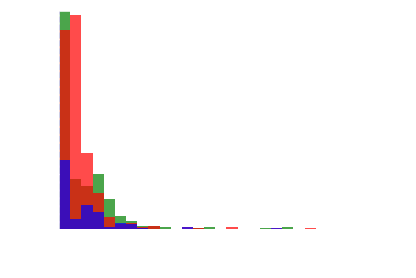

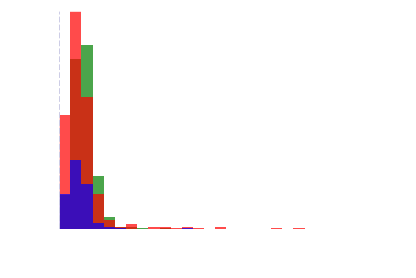

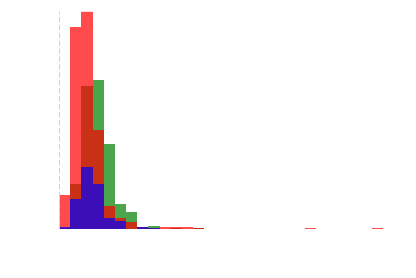

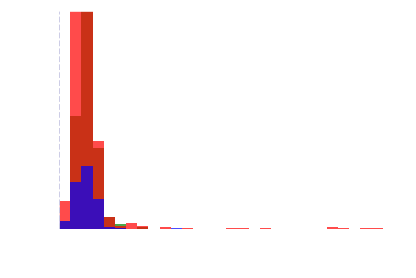

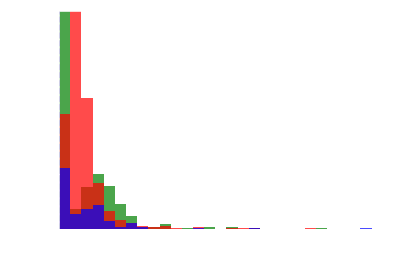

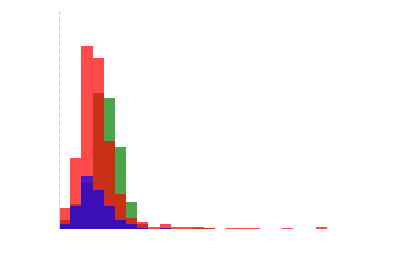

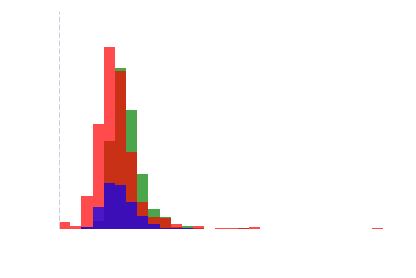

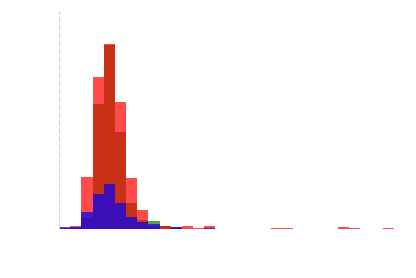

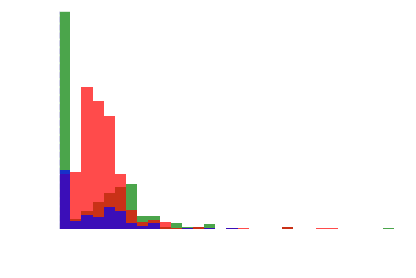

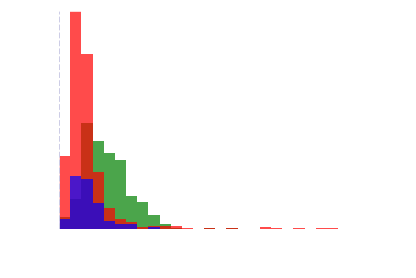

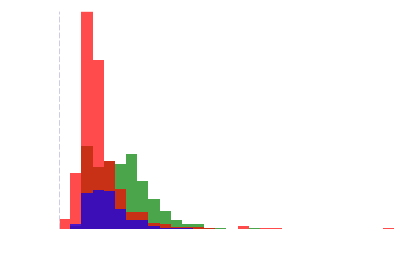

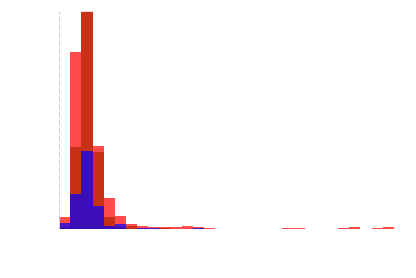

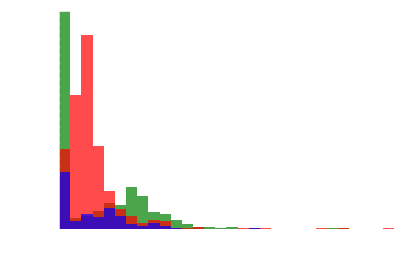

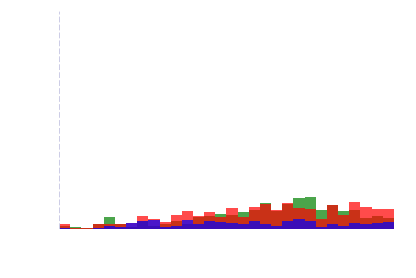

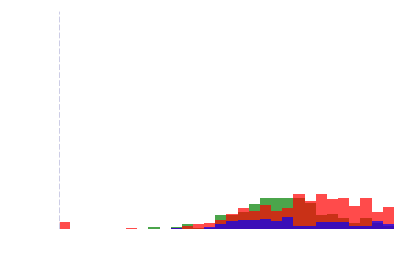

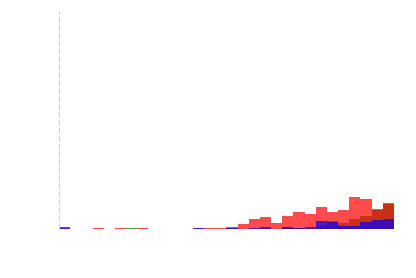

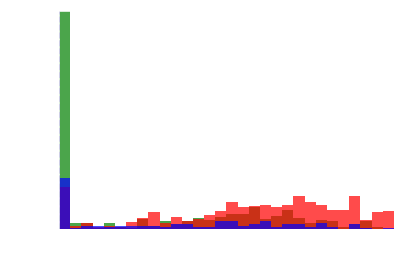

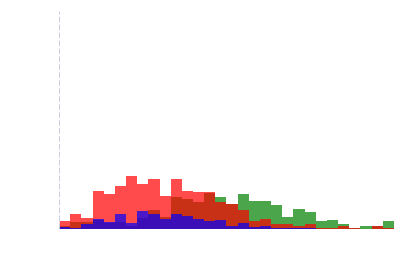

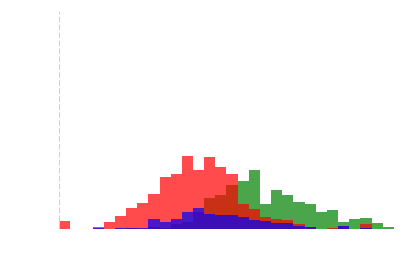

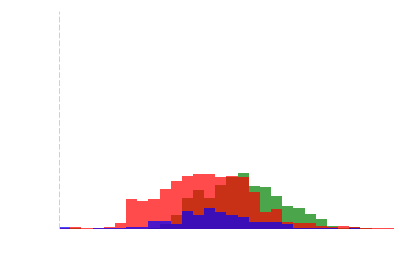

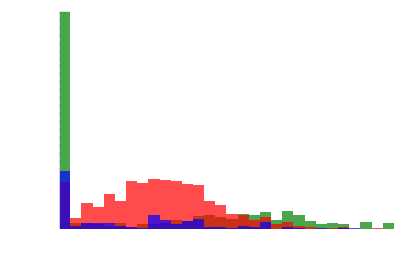

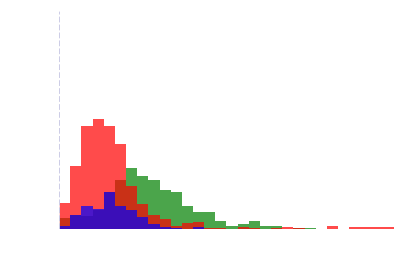

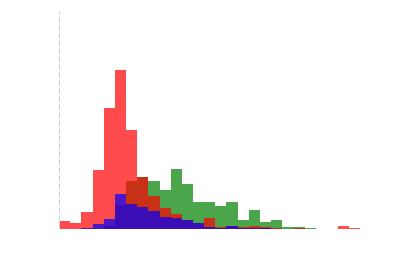

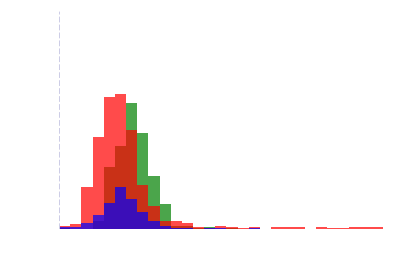

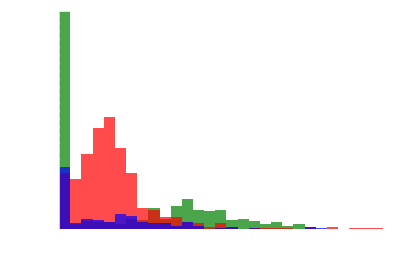

In [59]:
# MISS BAND CHECK --------------------------------

band = 4
for band in range(7):
    DE_check = make_df(X_test).iloc[:,band::7]
    make_df(DE_check)
    os.makedirs(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_band_check", exist_ok=True)
    os.chdir(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_band_check")

    # 1-index
    seasons = ["Summer", "Spring", "Autumn", "Winter"]
    seasons.sort()
    for i in range(7):
#         os.makedirs(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_band_check/obs_{labels[i]}", exist_ok=True)
        obs_true_lis = make_df(DE_check.to_numpy()[(results["pred"]==results["obs"]) * (results["obs"]==i)])
        obs_miss_lis = make_df(DE_check.to_numpy()[(results["pred"]!=results["obs"]) * (results["obs"]==i)])
    #     for j in range(4):
    #         fig = plt.figure()
    #         ax = fig.add_subplot(1,1,1)
    #         ax.set_title(f"OBS = {labels[i]}_{seasons[j]}_BAND5")
    #         ax.hist(obs_true_lis.iloc[:, j].values, label="TRUE", color="g", alpha=0.3, range=(-2000, 12000), bins=28)

    #         ax.hist(obs_miss_lis.iloc[:, j].values, label="MISS", color="r", alpha=0.3, range=(-2000, 12000), bins=28)
    #         ax.set_xlim([-2000, 12000])
    #         ax.set_ylim([0, 200])
    #         ax.axvline(0, ls = "--", color = "navy")
    #         ax.legend(loc='upper left')
    #         plt.savefig(f"./obs_{labels[i]}/{seasons[j]}_band_5.png")


        if i==4:
            look = 5
            aaa = make_df(DE_check.to_numpy()[(results["obs"]==look)])
            bbb = make_df(DE_check.to_numpy()[(results["obs"]==i) * (results["pred"]==look)])
            ccc = make_df(DE_check.to_numpy()[(results["obs"]==look) * (results["pred"]==i)])
            ddd = pd.concat([bbb, ccc])
            for j in range(4):
                fig = plt.figure()
                plt.rcParams["font.size"] = 12
                plt.style.use('dark_background')
                ax = fig.add_subplot(1,1,1)
                fig.patch.set_facecolor('white')  # 図全体の背景色
                fig.patch.set_alpha(0)  # 図全体の背景透明度
                ax.patch.set_facecolor('white')  # subplotの背景色
                ax.patch.set_alpha(0)  # subplotの背景透明度
                ax.set_xlabel("Values",    fontsize=18)
                ax.set_ylabel("Frequency", fontsize=18)
                
                lower = 0
                upper = 3000
                
                #一緒obs=pred
#                 ax.set_title(f"OBS = {labels[i]}_{seasons[j]}_BAND{band+1}")
                ax.hist(obs_true_lis.iloc[:, j].values, label=f"OBS_{labels[i]}_PRED_{labels[i]}", color="g", alpha=0.7, range=(0, upper), bins=30)

                #一緒obs=pred
                ax.hist(aaa.iloc[:, j].values, label=f"OBS_{labels[look]}_PRED_{labels[look]}", color="r", alpha=0.7, range=(0, upper), bins=30)
                ax.set_xlim([-0, upper])
                ax.set_ylim([0, 200])
                ax.axvline(0, ls = "--", color = "navy")
#                 ax.legend(loc='upper right').get_frame().set_alpha(0)

                #違うobs!=pred
                ax.hist(ddd.iloc[:, j].values, label=f"OBS_{labels[i]}_PRED_{labels[look]}", color="b", alpha=0.7, range=(0, upper), bins=30)
                ax.set_xlim([0, upper])
                ax.set_ylim([0, 200])
                ax.axvline(0, ls = "--", color = "navy")
#                 ax.legend(loc='upper right').get_frame().set_alpha(0)

                os.makedirs(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_band_check/{labels[i]}_and_{labels[look]}", exist_ok=True)
                plt.savefig(f"./{labels[i]}_and_{labels[look]}/{seasons[j]}_band{band+1}.png")


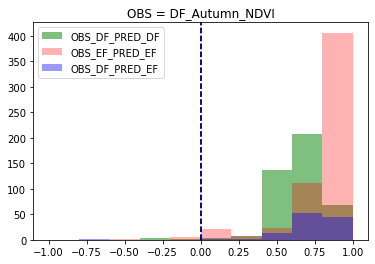

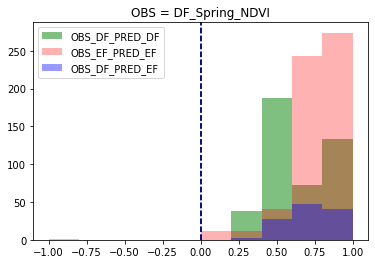

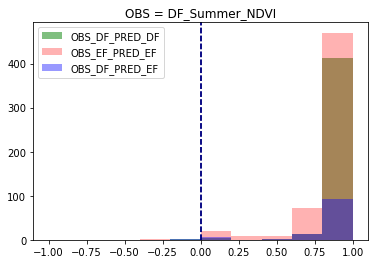

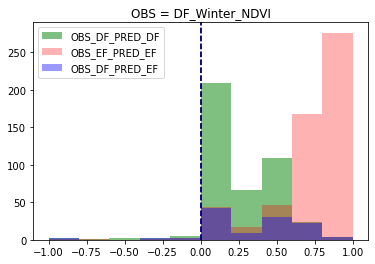

In [39]:
# NDVI check ----------------------------------------
band4 = make_df(X_test).iloc[:,3::7].values
band5 = make_df(X_test).iloc[:,4::7].values
DE_check = make_df((band5 - band4) / (band5 + band4)).fillna(0)
make_df(DE_check)
seasons = ["Summer", "Spring", "Autumn", "Winter"]
seasons.sort()
i=4
look = 5
obs_true_lis = make_df(DE_check.to_numpy()[(results["pred"]==results["obs"]) * (results["obs"]==i)])
obs_miss_lis = make_df(DE_check.to_numpy()[(results["pred"]!=results["obs"]) * (results["obs"]==i)])





aaa = make_df(DE_check.to_numpy()[(results["obs"]==look)])
bbb = make_df(DE_check.to_numpy()[(results["obs"]==i) * (results["pred"]==look)])
for j in range(4):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    #一緒obs=pred
    ax.set_title(f"OBS = {labels[i]}_{seasons[j]}_NDVI")
    ax.hist(obs_true_lis.iloc[:, j].values, label=f"OBS_{labels[i]}_PRED_{labels[i]}", color="g", alpha=0.5, range=(-1, 1), bins=10)

    #一緒obs=pred
    ax.hist(aaa.iloc[:, j].values, label=f"OBS_{labels[look]}_PRED_{labels[look]}", color="r", alpha=0.3, range=(-1, 1), bins=10)
#     ax.set_xlim([-2000, 12000])
#     ax.set_ylim([0, 200])
    ax.axvline(0, ls = "--", color = "navy")
    ax.legend(loc='upper left')

    #違うobs!=pred
    ax.hist(bbb.iloc[:, j].values, label=f"OBS_{labels[i]}_PRED_{labels[look]}", color="b", alpha=0.4, range=(-1, 1), bins=10)
#     ax.set_xlim([-2000, 12000])
#     ax.set_ylim([0, 200])
    ax.axvline(0, ls = "--", color = "navy")
    ax.legend(loc='upper left')

    os.makedirs(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_band_check/NDVI_{labels[i]}_and_{labels[look]}", exist_ok=True)
    plt.savefig(f"./NDVI_{labels[i]}_and_{labels[look]}/NDVI_{seasons[j]}_band{band+1}.png")


In [ ]:
# MISS BAND CHECK --------------------------------
for band in range(7):
    DE_check = make_df(X_test).iloc[:,band::7]
    make_df(DE_check)
    os.makedirs(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_band_check", exist_ok=True)
    os.chdir(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_band_check")

    # 1-index
    seasons = ["Summer", "Spring", "Autumn", "Winter"]
    seasons.sort()
    
    os.makedirs(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_band_check/obs_{labels[i]}", exist_ok=True)
    obs_true_dbf = make_df(DE_check.to_numpy()[(results["pred"]==results["obs"]) * (results["obs"]==5)])
    obs_miss_dbf = make_df(DE_check.to_numpy()[(results["pred"]!=results["obs"]) * (results["obs"]==5)])

    look = 1
    aaa = make_df(DE_check.to_numpy()[(results["obs"]==look)])
    bbb = make_df(DE_check.to_numpy()[(results["obs"]==i) * (results["pred"]==look)])
    for j in range(4):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        #一緒obs=pred
        ax.set_title(f"OBS = {labels[i]}_{seasons[j]}_BAND{band+1}")
        ax.hist([obs_true_lis.iloc[:, j], .values, label=f"OBS_{labels[i]}_PRED_{labels[i]}", color="g", alpha=0.5, range=(-2000, 12000), bins=28)

        #一緒obs=pred
        ax.hist(aaa.iloc[:, j].values, label=f"OBS_{labels[look]}_PRED_{labels[look]}", color="r", alpha=0.3, range=(-2000, 12000), bins=28)
        ax.set_xlim([-2000, 12000])
        ax.set_ylim([0, 200])
        ax.axvline(0, ls = "--", color = "navy")
        ax.legend(loc='upper left')

        #違うobs!=pred
        ax.hist(bbb.iloc[:, j].values, label=f"OBS_{labels[i]}_PRED_{labels[look]}", color="b", alpha=0.4, range=(-2000, 12000), bins=28)
        ax.set_xlim([-2000, 12000])
        ax.set_ylim([0, 200])
        ax.axvline(0, ls = "--", color = "navy")
        ax.legend(loc='upper left')

#                 os.makedirs(f"C:/Users/GE/Dropbox/Kairo/under90_results/1x1/gbdt/{file_time_name}/visualization/miss_band_check/{labels[i]}_and_{labels[look]}", exist_ok=True)
#                 plt.savefig(f"./{labels[i]}_and_{labels[look]}/{seasons[j]}_band{band+1}.png")
